# Consensus scaled form ADMM 
### using Gradient Descent  and Stopping Criteria
    code without mpi and slaves but this code works in a similiar way 

#### 1. parameter

In [ ]:
if(!require(data.table)) install.packages('data.table')
require(data.table)

# parameter setting
# here must be added thresholds for stopping criteria

# 1.
k = 10 # = number of slaves, or blocks?, or partitioned parts of whole data
n = 100
p = 10
eta = 0.01 # learning rate
lo = 10
epochs = 100
iterations = 100
# threshold
e_abs = 1
e_rel = 0.001
# running_time = c() # for saveing running time

# 2. 
# beta for slaves
local_beta = list()
local_dual = list()
for(i in 1:k)
{
  set.seed(i * 520)
  local_beta[[i]] = rnorm(p)
  set.seed(i * 960)
  local_dual[[i]] = rnorm(p)
}

# 3.
true_beta = c(rep(1,3), rep(0,p-3))
set.seed(960520)
global_beta = matrix(rnorm(p), p, 1)

# global objects list for broadcasting
global_obj = list(k = k, n = n, p = p, eta = eta, lo = lo, iterations = iterations)

#### 2. stopping function

In [ ]:
# stopping criteria
# 1.for pri and dual variables
e_pri_fun = function(p, e_abs, e_rel, x, z) # we didn't used c in constraint at consensus problem
{
  x_mat = matrix(numeric(0), p, 0)
  for(i in 1:k)
  {
    x_mat = cbind(x_mat, x[[i]])
  }
  return(sqrt(p) * e_abs + e_rel * max(norm(x_mat, "F"), norm(z, "F")))
}
e_dual_fun = function(p, e_abs, e_rel, u)
{
  u_mat = matrix(numeric(0), p, 0)
  for(i in 1:k)
  {
    u_mat = cbind(u_mat, u[[i]])
  }
  return(sqrt(p) * e_abs + e_rel * norm(u_mat, "F"))
}

# 2. for loss criteria
loss_function = function(beta)
{
  loss = 0
  for(i in 1:k)
  {
    data = as.matrix(fread(file = paste('C:/Users/dpelt/r_default/admm/admm_data/data', i, '.csv', sep=""), header = T))
    x = data[ ,1:p]
    y = data[ ,(p + 1)]
    loss = loss - t(y) %*% x %*% beta + colSums(log(1 + exp(x %*% beta)))
  }
  return(loss)
}

#### 3. data generation

In [ ]:
# data generation
for(i in 1:k)
{
  set.seed(i)
  x = matrix(rnorm(n * p), n , p)
  y = rbinom(n, size = 1, prob = 1 / (1 + exp(-x %*% true_beta)))
  fwrite(cbind(x,y), file = paste('C:/Users/dpelt/r_default/admm/admm_data/data', i, '.csv', sep=""))
}

#### 4. slave function

In [ ]:
# slave function
slavefunction_argmin_computing = function(data, beta, b, dual)
{
  maxiter = 5000
  x = data[, 1:global_obj$p]
  y = as.matrix(data[, (global_obj$p+1)])
  # limited by maxiter
  for(i in 1:maxiter)
  {
    grad = - matrix((t(y) %*% x) / global_obj$n, global_obj$p, 1) + (t(x) %*% (1 / (1 + exp(- x %*% b)))) / global_obj$n +
      matrix(global_obj$lo * (b - global_beta - dual), global_obj$p, 1)
    b = b - global_obj$eta * grad
    # if(i %% 10 == 0) cat(grad[1:10], '\n')
    # stopping criteria
    if(norm(grad, "F") < 1e-6) break
  }
    
  # not limited in iteration number
  # m = 1
  # while(T)
  # {
  #   # not divided by n
  #   grad = - matrix((t(y) %*% x) / global_obj$n, global_obj$p, 1) + (t(x) %*% (1 / (1 + exp(- x %*% b)))) / global_obj$n +
  #     matrix(global_obj$lo * (b - global_beta - dual), global_obj$p, 1)
  #   b = b - global_obj$eta * grad
  #   # if(m %% 10 == 0) cat(grad[1:10], '\n')
  #   # stopping criteria
  #   if(norm(grad, "F") < 1e-6) break
  #   # m = m + 1
  # }
  return(b)
}

#### 5. working part

In [ ]:
# initial_time = as.numeric(format(Sys.time(), "%s"))
for(t in 1:epochs)
{
  # like slave working
  for(i in 1:k)
  {
    b = local_beta[[i]]
    dual = local_dual[[i]]
    data = as.matrix(fread(file = paste('C:/Users/dpelt/r_default/admm/admm_data/data', i, '.csv', sep=""), header = T))
    local_beta[[i]] = slavefunction_argmin_computing(data, global_beta, b, dual)
  }
    
  # global beta update
  sum = rep(0, p)
  for(i in 1:k)
  {
    sum = sum + local_beta[[i]] + local_dual[[i]]
  }
  old_beta = global_beta
  global_beta = sum / k
    
  # dual variables update
  for(i in 1:k)
  {
    local_dual[[i]] = local_dual[[i]] + local_beta[[i]] - global_beta
  }
  # running_time = c(running_time, as.numeric(format(Sys.time(), "%s")) - initial_time)
  fwrite(as.matrix(global_beta), file = paste('C:/Users/dpelt/r_default/admm/beta2/beta2_', t, '.csv', sep=""))
    
  # check stopping criteria
  # 1. using optimaltiy condition
  # e_pri = e_pri_fun(p, e_abs, e_rel, local_beta, global_beta)
  # e_dual = e_dual_fun(p, e_abs, e_rel, local_dual)
  # b_mat = matrix(numeric(0), p, 0)
  # for(i in 1:k)
  # {
  #   b_mat = cbind(b_mat, local_beta[[i]])
  # }
  # r = b_mat - global_beta %*% matrix(rep(1, k), 1, k)
  # s = as.matrix(global_obj$lo * (old_beta - global_beta))
  # if(t %% 5 == 0) cat('1:', norm(r, "F"), '2:', norm(s, 'F'), '\n')
  # if(norm((r), "F") < e_pri && norm((s), "F") < e_dual) break
    
  # 2. using loss 
  cat('loss:', loss_function(global_beta), '\n')
  if(t > 1 && loss_function(global_beta) > loss_function(old_beta)) break
}
# fwrite(as.matrix(running_time), file = paste('C:/Users/dpelt/r_default/admm/running_time.csv', sep=""))

#### 6. loss ploting

In [ ]:
t = t - 1
# integrating global beta
total_beta = matrix(numeric(0), p, 0)
for(i in 1:t)
{
  total_beta = cbind(total_beta, 
                     as.matrix(fread(file = paste('C:/Users/dpelt/r_default/admm/beta2/beta2_', i, '.csv', sep=""))))
}

# loss computing
loss = rep(0, t)
for(i in 1:k)
{
  data = as.matrix(fread(file = paste('C:/Users/dpelt/r_default/admm/admm_data/data', i, '.csv', sep=""), header = T))
  x = data[ ,1:p]
  y = data[ ,(p + 1)]
  loss = loss - t(y) %*% x %*% total_beta + colSums(log(1 + exp(x %*% total_beta)))
}
fwrite(as.matrix(loss), file = paste('C:/Users/dpelt/r_default/admm/admm_loss2.csv', sep=""))

# save loss~running_time plot
# png(file = "/home/jeon/an/admm/admm_loss_plot2.png")
# running_time = as.matrix(fread(file = '/home/jeon/an/admm/running_time.csv', header = T))
# plot(running_time, loss)
plot(seq(1,t,1), loss)
# dev.off()

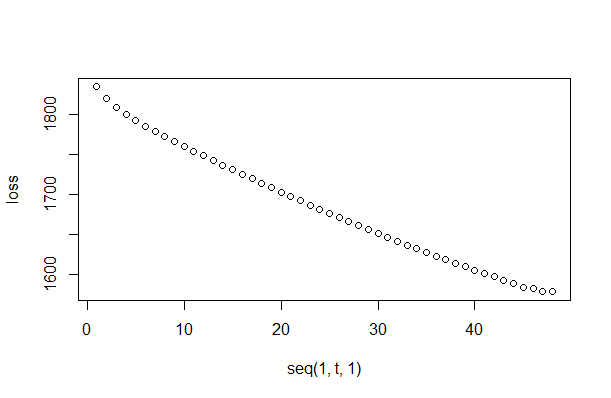